In [37]:
# %% 
import os
from pathlib import Path
from typing import Callable, Iterable, List, Optional, Union
from PIL import Image
import numpy as np
from numpy.random import choice
import math
import torch
from torch.functional import _return_counts
import torch.nn.functional as F
from skimage.color import label2rgb
from skimage.measure import label as measure_label
from matplotlib.cm import get_cmap
from torchvision import transforms as T
from torchvision.transforms import functional as TF
from torchvision.utils import draw_bounding_boxes, make_grid
from torchvision.ops import box_iou
import matplotlib.pyplot as plt
from IPython.display import display

import extract_utils as utils

# Global paths
dataset = "VOC2012"
root = Path("/data2/tmp/found_old")
images_list = root / dataset / "lists/images.txt"
images_root = root / dataset / f"images"
eigs_root = root / dataset / f"eigs"
features_root = root / dataset / f"features"
seg_root = root / dataset / f"multi_region_segmentation"
semseg_root = root / dataset / f"semantic_segmentations"

# Specific paths
eigs_dir = 'matting_laplacian_dino_vitb8_8x_lambda_0' 
features_dir = 'dino_vitb8'
image_downsample_factor = 8 
segmap_dir = 'laplacian_dino_vitb16_fixed_15'  # 'laplacian_dino_vitb8_fixed_15'
semseg_run = 'segmaps_e_d5_pca_0_s12'  # 'segmaps_e_d5_pca_0_s12'

# Segmentation
# preds_dir = Path('/data2/tmp/found_old/VOC2012/semantic_segmentations/patches/laplacian_dino_vitb8_fixed_15/segmaps_e_d12_pca_0_s12')
preds_dir = Path('/data_q1_d/extra-storage/found_new/outputs/generate/2021-11-17--00-10-22/preds')  # 2021-11-18--12-16-21/preds') #  
gt_dir = Path('/data_q1_d/extra-storage/found_new/outputs/generate/2021-11-17--00-10-22/gt')  # 2021-11-18--12-16-21/gt') #  

# Prepare
images_list = images_list.read_text().splitlines()

# Available
available_stems = [f.stem for f in gt_dir.iterdir()]

# Colors
colors = get_cmap('tab20', 21).colors[:, :3]
binary_colors = get_cmap('viridis')


def get_largest_cc(mask: np.array):
    from skimage.measure import label as measure_label
    labels = measure_label(mask)  # get connected components
    largest_cc_index = np.argmax(np.bincount(labels.flat)[1:]) + 1
    return labels == largest_cc_index


def resize_width(x: Image):
    w, h = x.size
    x = x.resize((384, (h * 384) // w))
    return TF.to_tensor(x)

In [55]:

# %%

# Quick script 
from tqdm import tqdm
nrow = 3
img_tensors = []
pbar = tqdm(preds_dir.iterdir())
nseg = 0
_files = []
for i, p in enumerate(pbar):
    if i % 100 == 99:
        pbar.set_description(f"{i/nseg}")
    gt = np.array(Image.open(str(p).replace('preds', 'gt')))
    
    # # Original
    # pred = np.array(Image.open(p))
    
    # New
    pred = np.array(Image.open(semseg_root / 'patches' / segmap_dir / semseg_run / f'{p.stem}.png').resize((gt.shape[1], gt.shape[0]), Image.NEAREST))
    
    # pred = np.array(Image.open(semseg_root / 'patches' / segmap_dir / semseg_run / f'{p.stem}.png').resize((gt.shape[1], gt.shape[0]), Image.NEAREST))
    _pred, counts = np.unique(pred, return_counts=True)
    nseg += len(pred)
    if len(counts) > 2:
        acc = ((gt == pred) * (gt != 0)).astype(float).sum() / (gt != 0).astype(float).sum()
        _files.append((p.name, counts, _pred, acc))

0.0025877504513303145: : 1449it [00:04, 315.63it/s]


In [56]:
# %% 

_sorted_files = sorted(_files, key=lambda x: -x[1].min())
# _sorted_files = sorted(_files, key=lambda x: -x[3])[200:400]
# _sorted_files = sorted(_files, key=lambda x: -x[3])[:100]
# _sorted_files[:4]
# list(map(lambda x: -x[1].min(), _sorted_files[:4]))

stem: 2010_001767


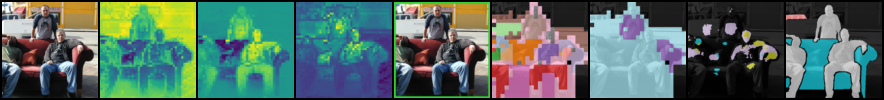





stem: 2010_002929


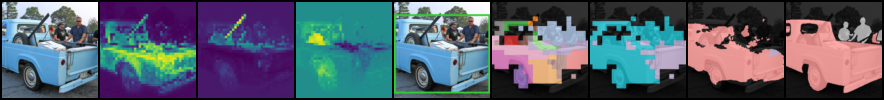





stem: 2008_001966


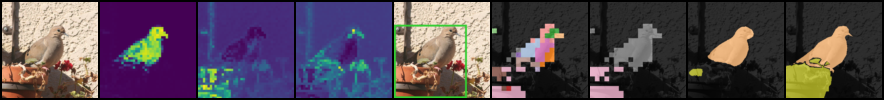





stem: 2007_000559


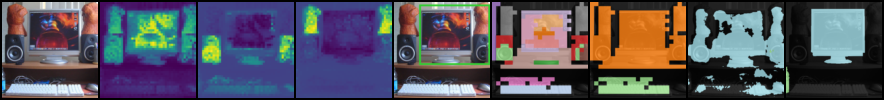





stem: 2007_006076


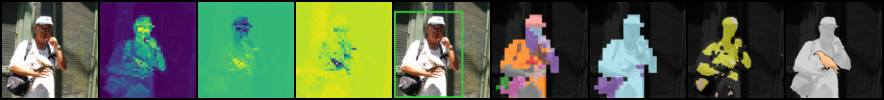





stem: 2010_001011


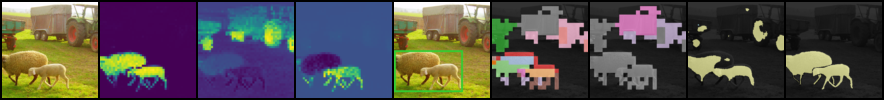





stem: 2008_004363


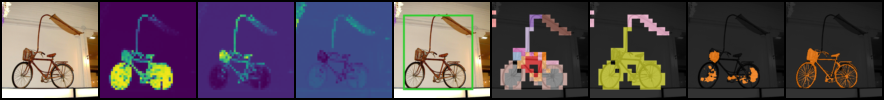





stem: 2008_006523


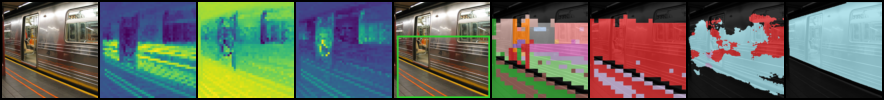





stem: 2010_000318


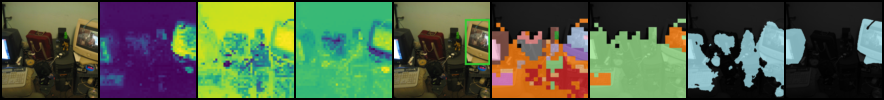





stem: 2007_004712


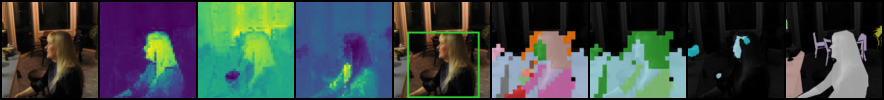





stem: 2007_003742


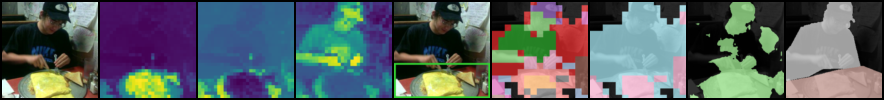





stem: 2007_009258


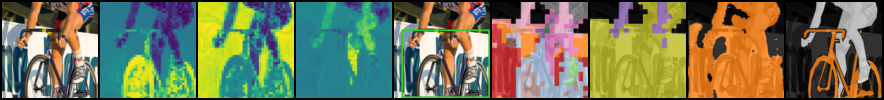





stem: 2010_004951


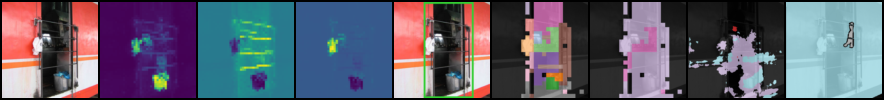





stem: 2010_004980


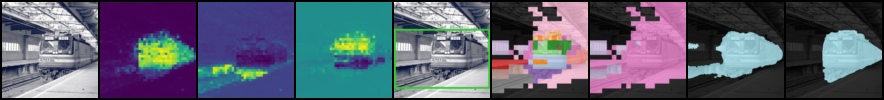





stem: 2011_001546


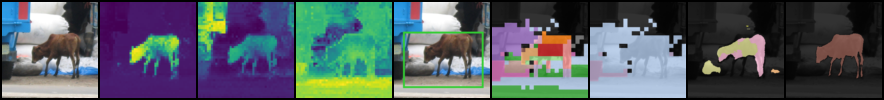





stem: 2011_003240


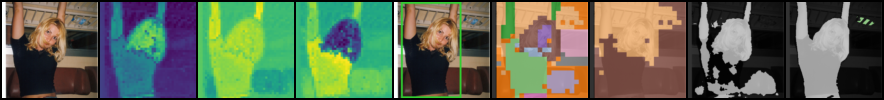





stem: 2007_007688


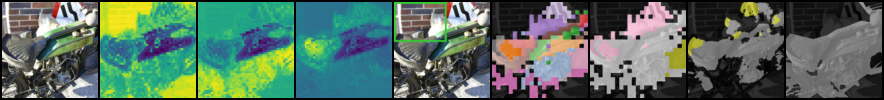





stem: 2008_004562


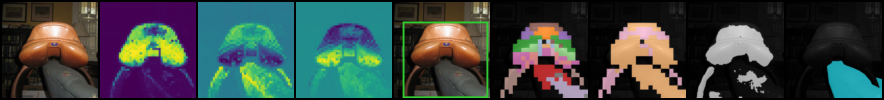





stem: 2009_002221


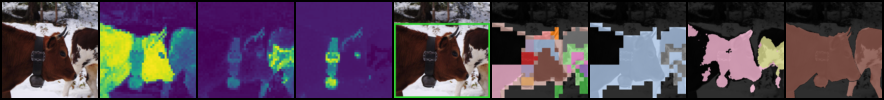





stem: 2009_003507


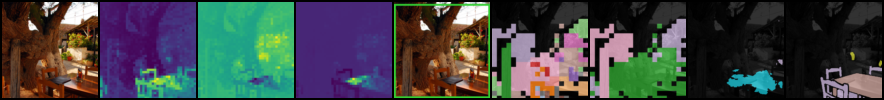





stem: 2007_005845


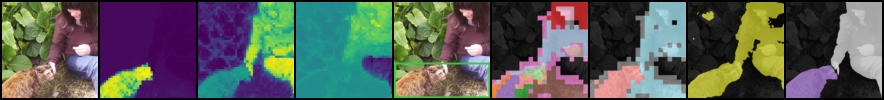





stem: 2007_009446


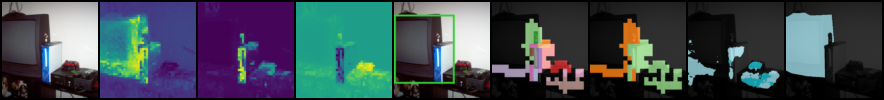





stem: 2010_004479


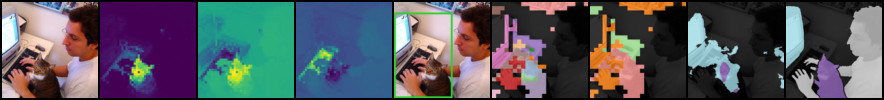





stem: 2008_000501


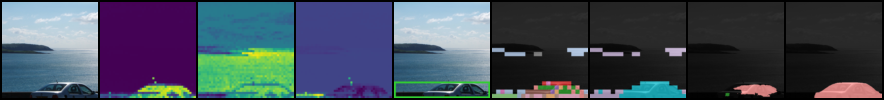





stem: 2010_004763


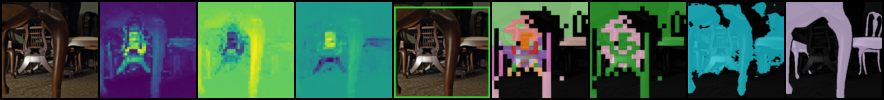





stem: 2008_001821


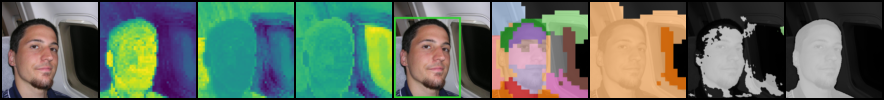





stem: 2007_005978


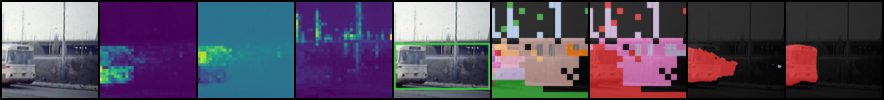





stem: 2009_004882


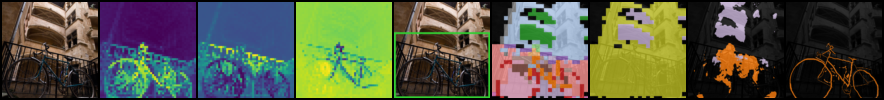





stem: 2010_001256


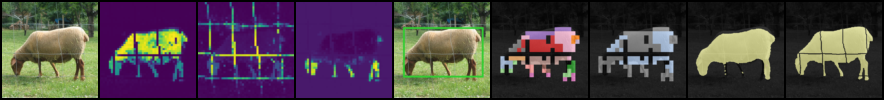





stem: 2011_000638


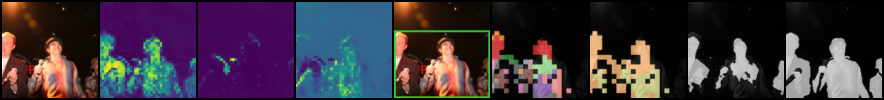





stem: 2011_002391


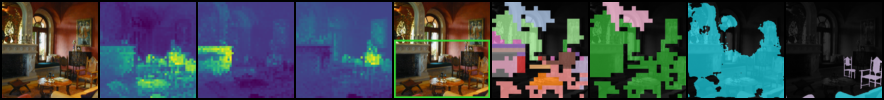





stem: 2008_005738


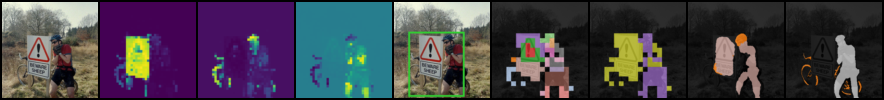





stem: 2007_004392


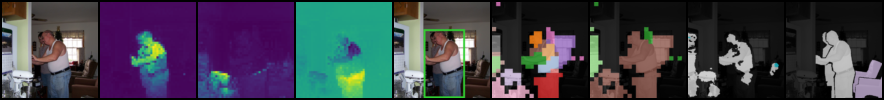





stem: 2009_002415


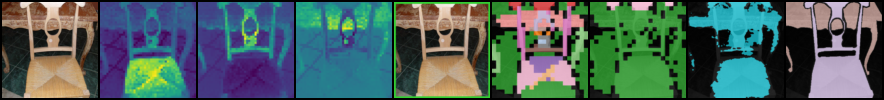





stem: 2008_004279


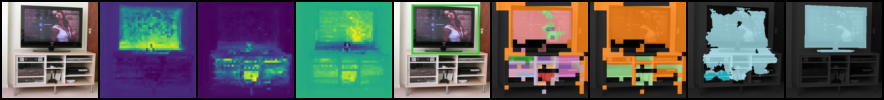





stem: 2010_000941


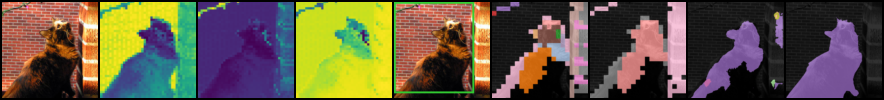





stem: 2009_004969


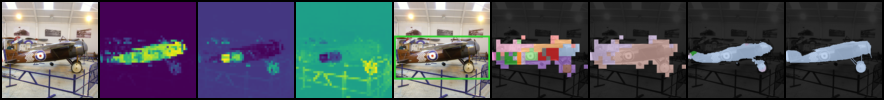





stem: 2011_001880


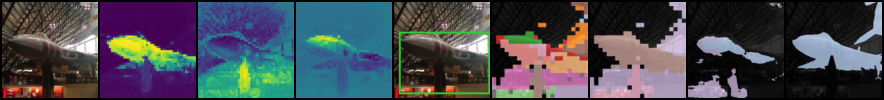





stem: 2008_005245


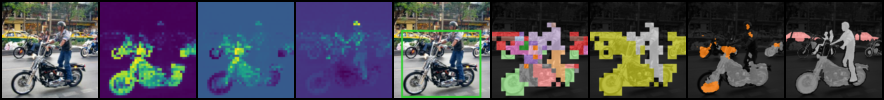





stem: 2011_001346


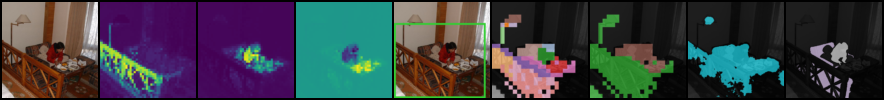





stem: 2008_002775


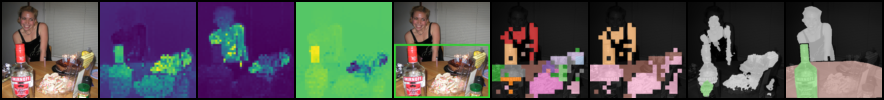





stem: 2008_006254


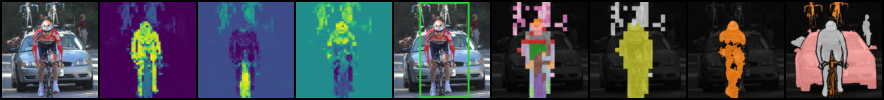





stem: 2007_003991


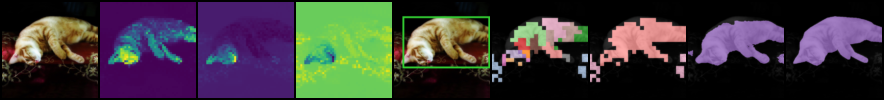





stem: 2008_004654


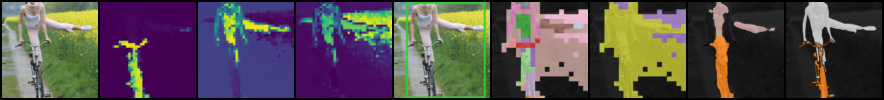





stem: 2007_004121


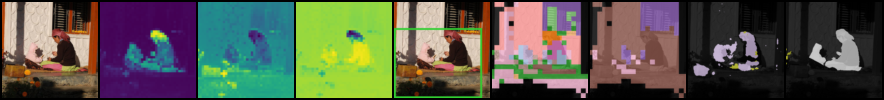





stem: 2007_009068


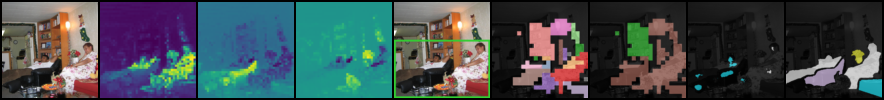





stem: 2011_000747


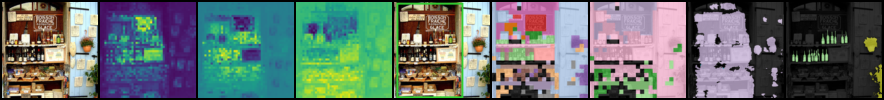





stem: 2009_004730


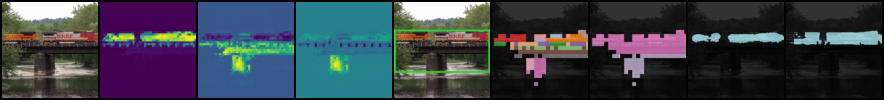





stem: 2008_002504


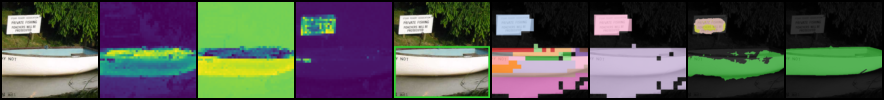





stem: 2008_000992


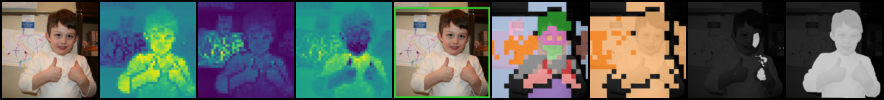

In [57]:
# %% 

# Inputs
# input_stems = ['2009_005089', '2009_000712', '2009_005137', '2010_004355', '2010_005531', '2007_001884', '2011_001350']
# input_stems = ['2009_005089', '2009_000712', '2010_004355', '2011_001350']
input_stems = [a[0][:-4] for a in _sorted_files]  # available_files
# input_stems = choice(input_stems, size=(10,), replace=False)

# Show images
all_output_dicts = []
for stem in input_stems[100:150]:

    # Paths
    image_file = images_root / f'{stem}.jpg'
    eigs_file = eigs_root / eigs_dir / f'{stem}.pth'
    features_file = features_root / features_dir / f'{stem}.pth'
    seg_file = seg_root / segmap_dir / f'{stem}.png'
    semseg_file = semseg_root / 'patches' / segmap_dir / semseg_run / f'{stem}.png'

    # Dict to hold outputs
    output_dict = {}

    # Load 
    image = Image.open(image_file)
    data_dict = {}
    data_dict.update(torch.load(features_file))
    data_dict.update(torch.load(eigs_file))

    # New transform
    transform = T.Compose([T.Resize(512), T.CenterCrop(512)])

    # Sign ambiguity
    eigenvectors = data_dict['eigenvectors']
    for k in range(eigenvectors.shape[0]):
        if 0.5 < torch.mean((eigenvectors[k] > 0).float()).item() < 1.0:  # reverse segment
            eigenvectors[k] = 0 - eigenvectors[k]
    
    # Get sizes
    B, C, H, W, P, H_patch, W_patch, H_pad, W_pad = utils.get_image_sizes(data_dict)
    H_pad_lr, W_pad_lr = H_pad // image_downsample_factor, W_pad // image_downsample_factor

    # Tensor
    image = transform(image)
    output_dict['image'] = image
    
    # Add to list
    for i in range(1, 4):
        eigenvector = eigenvectors[i].reshape(1, 1, H_pad_lr, W_pad_lr)
        eigenvector = F.interpolate(eigenvector, size=(H, W), mode='nearest')  # slightly off, but for visualizations this is okay
        plt.imsave('./tmp/tmp-img-matplotlib.png', eigenvector.squeeze().numpy())  # save to a temporary location
        eigenvector_image = Image.open('./tmp/tmp-img-matplotlib.png').convert('RGB') # load back from our temporary location
        output_dict[f'evec-{i}'] = transform(eigenvector_image)
    
    # Get eigenvector: largest connected component
    mask = F.interpolate(eigenvectors[1].reshape(1, 1, H_pad_lr, W_pad_lr), size=(H, W), mode='nearest')
    mask = TF.center_crop(TF.resize(mask, 512, interpolation=TF.InterpolationMode.NEAREST), 512)
    mask = (mask.squeeze().numpy() > 0)
    mask_largest_cc = get_largest_cc(mask)  # this or just the eigenvector? not sure, let's try this for now
    output_dict['mask'] = Image.fromarray(mask)
    output_dict['mask_largest_cc'] = Image.fromarray(mask_largest_cc)

    # Get bounding box
    where_mask = np.where(mask_largest_cc)
    ymin, ymax = min(where_mask[0]), max(where_mask[0]) + 1
    xmin, xmax = min(where_mask[1]), max(where_mask[1]) + 1
    boxes = [[xmin, ymin, xmax, ymax]]

    # Bounding boxes
    img = (TF.to_tensor(image) * 255).to(torch.uint8)
    img_pred = draw_bounding_boxes(img, boxes=torch.tensor(boxes), width=10, colors=['limegreen'])
    output_dict['bbox_image'] = TF.to_pil_image(img_pred)

    # Segmentations (without finetuning)
    segmap = np.array(TF.center_crop(TF.resize(Image.open(seg_file), 512, interpolation=TF.InterpolationMode.NEAREST), 512))
    semseg = np.array(TF.center_crop(TF.resize(Image.open(semseg_file), 512, interpolation=TF.InterpolationMode.NEAREST), 512))
    segmap_label_indices, segmap_label_counts = np.unique(segmap, return_counts=True)
    semseg_label_indices, semseg_label_counts = np.unique(semseg, return_counts=True)
    blank_segmap_overlay = label2rgb(label=segmap, image=np.full_like(image, 128), colors=colors[segmap_label_indices[segmap_label_indices != 0]], bg_label=0, alpha=1.0)
    blank_semseg_overlay = label2rgb(label=semseg, image=np.full_like(image, 128), colors=colors[semseg_label_indices[semseg_label_indices != 0]], bg_label=0, alpha=1.0)
    image_segmap_overlay = label2rgb(label=segmap, image=np.array(image), colors=colors[segmap_label_indices[segmap_label_indices != 0]], bg_label=0, alpha=0.8)
    image_semseg_overlay = label2rgb(label=semseg, image=np.array(image), colors=colors[semseg_label_indices[semseg_label_indices != 0]], bg_label=0, alpha=0.8)
    output_dict['segmap_image'] = Image.fromarray((image_segmap_overlay * 255).astype(np.uint8))
    output_dict['semseg_image'] = Image.fromarray((image_semseg_overlay * 255).astype(np.uint8))

    # Segmentation
    pred_image = Image.open(preds_dir / f'{stem}.png')
    gt_image = Image.open(gt_dir / f'{stem}.png')
    # assert image.size == pred_image.size == gt_image.size, (image.size, pred_image.size, gt_image.size)

    # Pred and ground truth
    pred = np.array(TF.center_crop(TF.resize(pred_image, 512, interpolation=TF.InterpolationMode.NEAREST), 512))
    gt = np.array(TF.center_crop(TF.resize(gt_image, 512, interpolation=TF.InterpolationMode.NEAREST), 512))

    # Unknown region --> 0
    pred[pred == 255] = 0
    gt[gt == 255] = 0

    # Color
    pred_label_indices, pred_label_counts = np.unique(pred, return_counts=True)
    gt_label_indices, gt_label_counts = np.unique(gt, return_counts=True)
    # 
    blank_pred_overlay = label2rgb(label=pred, image=np.full_like(image, 128), colors=colors[pred_label_indices[pred_label_indices != 0]], bg_label=0, alpha=1.0)
    blank_gt_overlay = label2rgb(label=gt, image=np.full_like(image, 128), colors=colors[gt_label_indices[gt_label_indices != 0]], bg_label=0, alpha=1.0)
    # 
    image_pred_overlay = label2rgb(label=pred, image=np.array(image), colors=colors[pred_label_indices[pred_label_indices != 0]], bg_label=0, alpha=0.8)
    image_gt_overlay = label2rgb(label=gt, image=np.array(image), colors=colors[gt_label_indices[gt_label_indices != 0]], bg_label=0, alpha=0.8)

    # Finetuned
    output_dict['semseg_pred'] = Image.fromarray((image_pred_overlay * 255).astype(np.uint8))
    output_dict['semseg_gt'] = Image.fromarray((image_gt_overlay * 255).astype(np.uint8))

    # Create grid for now
    tensor_grid = []
    for k, v in output_dict.items():
        if k in ['image', 'evec-1', 'evec-2', 'evec-3', 'bbox_image', 'segmap_image', 'semseg_image', 'semseg_pred', 'semseg_gt']:
            img_tensor = TF.to_tensor(TF.resize(v, 96).convert('RGB'))  # temp resolution 128 for display
            tensor_grid.append(img_tensor)
    tensor_grid = make_grid(tensor_grid, nrow=len(tensor_grid))
    tensor_grid_image = TF.to_pil_image(tensor_grid)
    print(f'stem: {stem}')
    display(tensor_grid_image)
    print("\n\n\n")

    # # Add to grid for later
    # all_output_dicts.append(output_dict)

# %%

# # Create tensor grid
# keys_to_show = ['image', 'evec-1', 'evec-2', 'evec-3', 'bbox_image', 'segmap_image', 'semseg_pred']
# tensor_grid = []
# for d in all_output_dicts:
#     for k, v in d.items():
#         if k in keys_to_show:
#             img_tensor = TF.to_tensor(TF.resize(v, 384).convert('RGB'))  # temp resolution 128 for display
#             tensor_grid.append(img_tensor)
# tensor_grid = make_grid(tensor_grid, nrow=len(keys_to_show), pad_value=1.0)
# tensor_grid_image = TF.to_pil_image(tensor_grid, )

# tensor_grid_image

# %%
